In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **패키지 불러오기**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from tqdm import tqdm


In [5]:
import os
os.chdir('/content/drive/My Drive/러닝스푼스')

# **데이터 불러오기**

In [6]:
df_train = pd.read_csv('funda_train.csv')
df_sub = pd.read_csv('submission.csv')


print(df_train.shape)

(6556613, 9)


In [7]:
df_train.head(3)

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   card_id           int64  
 2   card_company      object 
 3   transacted_date   object 
 4   transacted_time   object 
 5   installment_term  int64  
 6   region            object 
 7   type_of_business  object 
 8   amount            float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


In [9]:
num_store=len(df_train['store_id'].unique())
num_card=len(df_train['card_company'].unique())
num_region=len(df_train['region'].unique())
num_business=len(df_train['type_of_business'].unique())
num_installment=len(df_train['installment_term'].unique())

print(f'store_id : {num_store}')
print(f'card_company : {num_card}')
print(f'region : {num_region}')
print(f'type_of_business : {num_business}')
print(f'installment_term : {num_installment}',end='\n')

store_id : 1967
card_company : 8
region : 181
type_of_business : 146
installment_term : 34


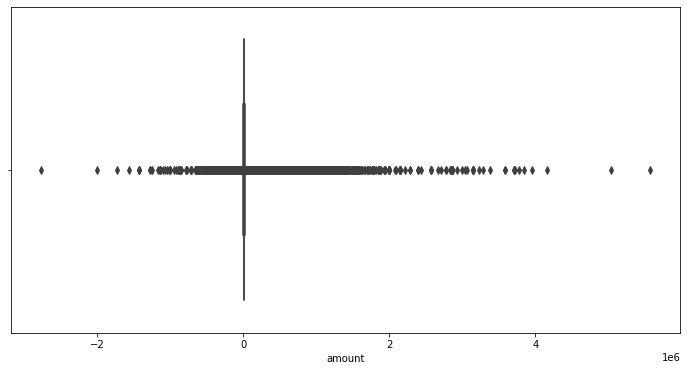

In [10]:
plt.figure(figsize=(12,6))
sns.boxplot(x='amount',data=df_train)
#-가 있다?

In [11]:

#환불 정보임을 알 수 있다
df_train[df_train['amount']<0][:5]

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
41,0,40,a,2016-06-10,17:26,2,NaN,기타 미용업,-8571.428571
347,0,285,a,2016-08-04,17:52,0,NaN,기타 미용업,-1857.142857
731,0,473,g,2016-10-17,10:32,0,NaN,기타 미용업,-2000.000000
831,0,230,b,2016-11-03,15:36,0,NaN,기타 미용업,-85.714286
944,0,138,a,2016-11-28,13:21,0,NaN,기타 미용업,-57.142857


In [12]:
df_train.isna().sum()

store_id                  0
card_id                   0
card_company              0
transacted_date           0
transacted_time           0
installment_term          0
region              2042766
type_of_business    3952609
amount                    0
dtype: int64

In [13]:
print('region nan data :',(df_train.region.isna().sum()/len(df_train)).round(3))
print('type_of_business nan data :',(df_train.type_of_business.isna().sum()/len(df_train)).round(3))

region nan data : 0.312
type_of_business nan data : 0.603


[알 수 있는 것들]

1.데이터 갯수가 60만개 이상 > 보통의 방법으로는 처리시간이 많이 걸림. > store_id로 나눠 생각한다.

2.transacted_date와 transacted_time 을 합쳐 datetime 형식으로 바꾼다. > 시계열 데이터 처리를 위한다.

3.숫자형 데이터의 describe()를 봤을 때, amount의 음수가 있다.

4.시계열 데이터를 위해 월별 데이터를 모은다.

5.결측율이 region과 type_of_business 가 각각 30%와 60%를 넘어가며, 채우는데 더 오랜 시간이 걸릴걸로 보아 제거한다.

# 데이터 전처리

In [14]:
df_train

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000
...,...,...,...,...,...,...,...,...,...
6556608,2136,4663855,d,2019-02-28,23:20,0,제주 제주시,기타 주점업,-4500.000000
6556609,2136,4663855,d,2019-02-28,23:24,0,제주 제주시,기타 주점업,4142.857143
6556610,2136,4663489,a,2019-02-28,23:24,0,제주 제주시,기타 주점업,4500.000000
6556611,2136,4663856,d,2019-02-28,23:27,0,제주 제주시,기타 주점업,571.428571


In [15]:
#합치기: 날짜와 시간으로 분리된 변수를 합쳐줍니다 
df_train['date']=df_train['transacted_date']+' '+df_train['transacted_time']
df_train['date']=pd.to_datetime(df_train['date'])

In [16]:
df_train

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,date
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857,2016-06-01 13:13:00
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857,2016-06-01 18:12:00
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000,2016-06-01 18:52:00
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857,2016-06-01 20:22:00
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000,2016-06-02 11:06:00
...,...,...,...,...,...,...,...,...,...,...
6556608,2136,4663855,d,2019-02-28,23:20,0,제주 제주시,기타 주점업,-4500.000000,2019-02-28 23:20:00
6556609,2136,4663855,d,2019-02-28,23:24,0,제주 제주시,기타 주점업,4142.857143,2019-02-28 23:24:00
6556610,2136,4663489,a,2019-02-28,23:24,0,제주 제주시,기타 주점업,4500.000000,2019-02-28 23:24:00
6556611,2136,4663856,d,2019-02-28,23:27,0,제주 제주시,기타 주점업,571.428571,2019-02-28 23:27:00


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 10 columns):
 #   Column            Dtype         
---  ------            -----         
 0   store_id          int64         
 1   card_id           int64         
 2   card_company      object        
 3   transacted_date   object        
 4   transacted_time   object        
 5   installment_term  int64         
 6   region            object        
 7   type_of_business  object        
 8   amount            float64       
 9   date              datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 500.2+ MB


In [18]:
#시간을 index로 해줍니다
df_train.set_index('date', inplace=True)

In [19]:
df_train

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
date,,,,,,,,,
2016-06-01 13:13:00,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
2016-06-01 18:12:00,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2016-06-01 18:52:00,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
2016-06-01 20:22:00,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
2016-06-02 11:06:00,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000
...,...,...,...,...,...,...,...,...,...
2019-02-28 23:20:00,2136,4663855,d,2019-02-28,23:20,0,제주 제주시,기타 주점업,-4500.000000
2019-02-28 23:24:00,2136,4663855,d,2019-02-28,23:24,0,제주 제주시,기타 주점업,4142.857143
2019-02-28 23:24:00,2136,4663489,a,2019-02-28,23:24,0,제주 제주시,기타 주점업,4500.000000


In [20]:
df_train.index

DatetimeIndex(['2016-06-01 13:13:00', '2016-06-01 18:12:00',
               '2016-06-01 18:52:00', '2016-06-01 20:22:00',
               '2016-06-02 11:06:00', '2016-06-02 13:09:00',
               '2016-06-02 15:33:00', '2016-06-02 17:18:00',
               '2016-06-02 18:30:00', '2016-06-02 19:56:00',
               ...
               '2019-02-28 22:35:00', '2019-02-28 22:43:00',
               '2019-02-28 22:45:00', '2019-02-28 23:03:00',
               '2019-02-28 23:20:00', '2019-02-28 23:20:00',
               '2019-02-28 23:24:00', '2019-02-28 23:24:00',
               '2019-02-28 23:27:00', '2019-02-28 23:54:00'],
              dtype='datetime64[ns]', name='date', length=6556613, freq=None)

In [21]:
#월별로 resample
data_month=pd.DataFrame()
for i in tqdm(df_train.store_id.unique()):
    data_num=df_train[df_train.store_id==i]
    sum_amount=data_num['amount'].resample(rule='m').sum()
    data_mon=pd.concat([sum_amount],axis=1)
    data_mon.insert(0,'store_id',i)
    data_month=pd.concat([data_month,data_mon],axis=0)
    
#data_month.head(10)

100%|██████████| 1967/1967 [00:31<00:00, 62.41it/s]


In [22]:
data_month

,store_id,amount
date,,
2016-06-30,0,7.470000e+05
2016-07-31,0,1.005000e+06
2016-08-31,0,8.715714e+05
2016-09-30,0,8.978571e+05
2016-10-31,0,8.354286e+05
...,...,...
2018-10-31,2136,2.012214e+06
2018-11-30,2136,2.135429e+06
2018-12-31,2136,2.427429e+06


# **모델링:단순 이동평균(SMA)**

In [23]:
def sub(df, n):
    concat_3mon=pd.DataFrame(index=pd.to_datetime(['2019-03-31','2019-04-30','2019-05-31']))
    df_sma=pd.DataFrame(columns=['store_id', 'amount'])
    
    for i in data_month['store_id'].unique():
        df_set=pd.DataFrame(df[df['store_id']==i].amount)
        sma_train=pd.concat([df_set, concat_3mon], axis=0)
        num = sma_train.amount.rolling(window=n,min_periods=1).mean().values[-3:].sum()
        df_sma.loc[i, 'store_id']=i
        df_sma.loc[i, 'amount']=num
        
    return df_sma

In [24]:
#함수 풀어 보기

In [25]:
concat_3mon=pd.DataFrame(index=pd.to_datetime(['2019-03-31','2019-04-30','2019-05-31']))
 #예측값이 포함된 빈 데이터 프레임을 만들어 줍니다.
df_set=pd.DataFrame(data_month[data_month['store_id']==2].amount) 
#store_id별 amount가 담긴 df_set데이터 프레임을 만들어 주고
sma_train=pd.concat([df_set, concat_3mon], axis=0)
 #store_id별로 df_set에 concat_3mon을 합쳐줍니다

In [26]:
#store_id 별 sma_train은 아래와 같습니다.
sma_train

,amount
2016-06-30,260714.285714
2016-07-31,82857.142857
2016-08-31,131428.571429
2016-09-30,142857.142857
2016-10-31,109714.285714
2016-11-30,198571.428571
2016-12-31,160000.000000
2017-01-31,180714.285714
2017-02-28,154285.714286
2017-03-31,43571.428571


In [27]:
#단순이동 평균기법을 사용해서 마지막 3일의 예측치를 구해줍니다.
num = sma_train.amount.rolling(window=4, min_periods=1).mean()

In [28]:
num

2016-06-30    260714.285714
2016-07-31    171785.714286
2016-08-31    158333.333333
2016-09-30    154464.285714
2016-10-31    116714.285714
2016-11-30    145642.857143
2016-12-31    152785.714286
2017-01-31    162250.000000
2017-02-28    173392.857143
2017-03-31    134642.857143
2017-04-30    145000.000000
2017-05-31    146428.571429
2017-06-30    138000.000000
2017-07-31    178892.857143
2017-08-31    176035.714286
2017-09-30    187642.857143
2017-10-31    224178.571429
2017-11-30    235607.142857
2017-12-31    247750.000000
2018-01-31    264464.285714
2018-02-28    276000.000000
2018-03-31    260214.285714
2018-04-30    271464.285714
2018-05-31    314750.000000
2018-06-30    325107.142857
2018-07-31    450000.000000
2018-08-31    493571.428571
2018-09-30    495535.714286
2018-10-31    534464.285714
2018-11-30    408500.000000
2018-12-31    379214.285714
2019-01-31    361000.000000
2019-02-28    357714.285714
2019-03-31    415142.857143
2019-04-30    452357.142857
2019-05-31    496857

In [29]:
#min_periods가 없다면 결측치가 발생합니다. 왜? 앞 뒤로 없기 때문에
num = sma_train.amount.rolling(window=4).mean()
num

2016-06-30              NaN
2016-07-31              NaN
2016-08-31              NaN
2016-09-30    154464.285714
2016-10-31    116714.285714
2016-11-30    145642.857143
2016-12-31    152785.714286
2017-01-31    162250.000000
2017-02-28    173392.857143
2017-03-31    134642.857143
2017-04-30    145000.000000
2017-05-31    146428.571429
2017-06-30    138000.000000
2017-07-31    178892.857143
2017-08-31    176035.714286
2017-09-30    187642.857143
2017-10-31    224178.571429
2017-11-30    235607.142857
2017-12-31    247750.000000
2018-01-31    264464.285714
2018-02-28    276000.000000
2018-03-31    260214.285714
2018-04-30    271464.285714
2018-05-31    314750.000000
2018-06-30    325107.142857
2018-07-31    450000.000000
2018-08-31    493571.428571
2018-09-30    495535.714286
2018-10-31    534464.285714
2018-11-30    408500.000000
2018-12-31    379214.285714
2019-01-31    361000.000000
2019-02-28    357714.285714
2019-03-31              NaN
2019-04-30              NaN
2019-05-31          

In [30]:
for i in tqdm(range(4, 7)):
    sma_sub = sub(data_month, i)
    sma_sub.to_csv(f'funda_{i}sma_sub.csv',index=False)

100%|██████████| 3/3 [00:20<00:00,  6.96s/it]


In [31]:
sub(data_month, 3)

,store_id,amount
0,0,NaN
1,1,NaN
2,2,NaN
4,4,NaN
5,5,NaN
...,...,...
2132,2132,NaN
2133,2133,NaN
2134,2134,NaN
2135,2135,NaN
